# Devoir 3 : Le modèle Leaky-Integrate-and-Fire

Dans ce devoir maison, vous allez encore vous familiariser avec le modèle LIF, qui est un modèle assez simple et puissant pour décrire l'activité des neurones. Plus précisemment, vous allez 

(1) simuler le modèle d'un neurone LIF sans bruit pour vérifier que l'expression analytique que nous avons obtenue pour le taux de décharge est correcte, et

(2) simuler le modèle LIF avec bruit pour extraire les temps de décharge et comparer le CV entre le 'mean-driven' régime (presque déterministe) et le régime d'activité irrégulière.

Ce devoir contient une petite partie *bonus* qui vous permet d'obtenir des points supplémentaires, par ex. pour combler des points qui vous manqueraient ailleurs.

## 1.  LIF  sans bruit : comparaison de la courbe f-I obtenue analytiquement et par simulation du modèle


### Rappel : Dynamique sous-seuil du LIF sans bruit 

Pour rappel, la dynamique **sous-seuil** (!) d'un neurone LIF _sans bruit_ est donnée par l'équation

$$\frac{dV}{dt} = \frac{1}{\tau}(E_L - V + RI )$$

Chaque fois que le potentiel $V$ franchit un seuil $V_{\rm seuil}$ par le bas, le modèle stipule qu'un PA est émis, et par la suite le potentiel est remis à sa valeur de "reset", $V\to V_{\rm reset}$.

Comme dans le TD3, nous considérons ici pour simplicité que $E_L=0$ mV (ou de manière équivalente, que $V$ est mésuré rélatif à $E_L$), ainsi que les paramètres suivants : $\tau=20$ ms et $R=1$ MOhm pour la dynamique sous-seuil, et $V_{\rm seuil}=20$ mV avec $V_{\rm reset}=0$ mV pour le mécanisme de décharge. 


### Exercice :

Déterminez la courbe $f(I)$ pour des valeurs de $I$ de 10 à 30 nA,  `Ivalues = np.arange(10,30,0.1)`, en simulant le LIF sans bruit pour une durée de 5s, `T = 5000 # ms`. Pour chaque valeur de $I$, enregistrez les temps auxquels des spikes sont émis. Le taux de décharge $r$ peut être obtenu de deux manières : 

(a) $r = N/T$, où $N$ est le nombre de spikes observés pendant une durée $T$,

(b) $r = 1/\bar T_{ISI}$, où $\bar T_{ISI}$ est le ISI (intervalle entre deux spikes) moyen.

Créez un array pour les taux de décharge avec autant d'entrées que vous avez de valeurs de I. Utilisez ce que nous avons fait dans le dernier TD pour simuler le LIF dans un boucle sur les courants, et écrivez le taux de décharge pour chaque I dans l'array respectif.

Plottez le résultat pour le taux de décharge obtenu avec la simulation ensemble avec le résultat théorique que nous avons calculé dans le TD,

$f(I) = \left(\tau \log \frac{V_{reset}-RI}{V_{seuil}-RI}\right)^{-1}$ .

(Attention, ne pas confondre la fonction $f$ ici avec la fonction qui désigne la dérivée dans une équation différentielle type ; ici, c'est $f$ comme "fréquence".)

**Astuces :** La fonction `np.diff` permet de calculer les differences entre les valeurs consécutives d'un array ou d'une liste (pour des arrays d'une dimension, c'est équivalent à `a[1:] - a[:-1]`). La fonction `np.mean` permet de calculer la moyenne sur un array ou une liste. 

In [4]:
# import necessary modules for numerics and plotting
%matplotlib notebook 
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Paramètres, définitions

R = 1 # MOhm
tau = 20 # ms
Vseuil = 20 # mV
Vreset = 0. 


def fI_analytique(I):
    """Courbe f-I pour LIF
    (résultat théorique). Retourne 
    le taux de décharge en Hz pour un
    courant injecté I en nA."""
    T = -tau*np.log((Vseuil-R*I)/(Vreset-R*I)) # ms
    return 1e3/T # Hz

# Definition of the dynamics
# (function returning dV/dt)

def dVdt(V,I):
    """Dynamique sous-seuil pour LIF). 
    Retourne la dérivé du potentiel membranaire
    (en mV/ms) comme fonction du potentiel 
    et le courant injecté I (en mV)."""
    return (R*I-V)/tau

In [9]:
# Simulation du LIF

# Discretization of time
dt = 0.01 # ms (much shorter than tau)
T = 5000 # ms 
nt = int(T/dt)
t = dt*np.arange(nt)

# Boucle sur les différentes valeurs de I
Ivalues = np.arange(10,30,0.1)
nI = len(Ivalues)

rates_a = np.zeros(nI)
rates_b = np.zeros(nI)

for j,I in enumerate(Ivalues):
    # initialisation
    spiketimes = []
    V = np.zeros(nt)
    V[0] = Vreset # start at reset potential (not necessary)

    # Euler integration
    for i in range(nt-1):
        # subthreshold dynamics according to differential equation for V(t)
        V[i+1] = V[i] + dt*dVdt(V[i], I)

        # check whether we hit the threshold!
        if V[i+1] > Vseuil:
            spiketimes.append(dt*i)
            V[i+1] = Vreset
            
    # calculer le taux de décharge
    
    # (a) r = N/T
    rates_a[j] = len(spiketimes)/T*1000 # convertir en Hz=1/s,
                                        # les 'spiketimes' sont en ms
    
    # (b) r = <ISIs>
    isis = np.diff(spiketimes)
    rates_b[j] = 1000/isis.mean()
    


/Users/jranft/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice.


/Users/jranft/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log
  


<IPython.core.display.Javascript object>


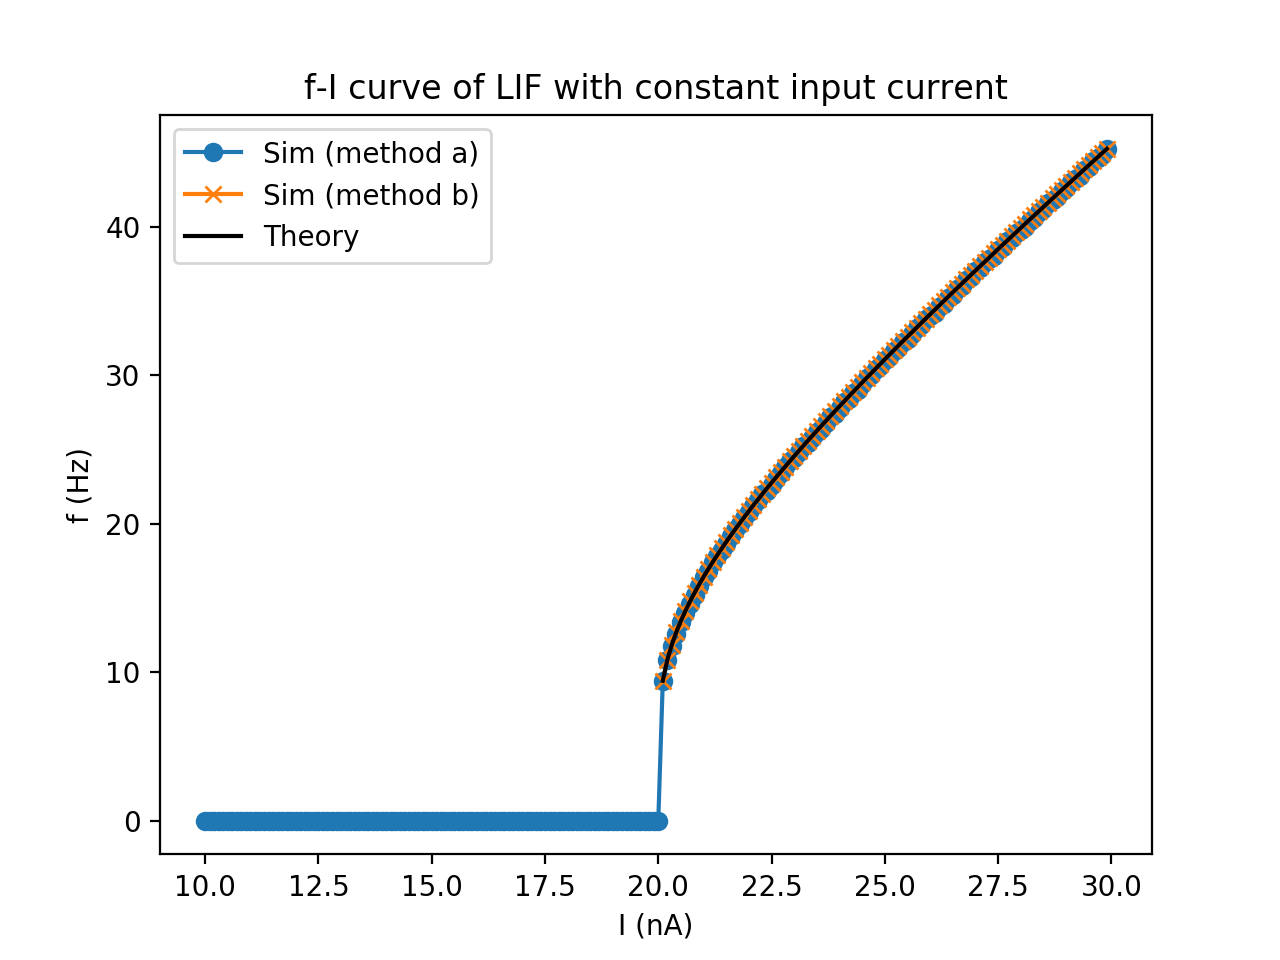

In [15]:
rates_theory = fI_analytique(Ivalues)

fig, ax = plt.subplots()
ax.set_title('f-I curve of LIF with constant input current')
ax.plot(Ivalues, rates_a, 'o-', label='Sim (method a)')
ax.plot(Ivalues, rates_b, 'x-', label='Sim (method b)')
ax.plot(Ivalues, rates_theory, 'k-', label='Theory')
ax.set_xlabel('I (nA)')
ax.set_ylabel('f (Hz)')
ax.legend()

## 2. LIF avec bruit


Maintenant, en présence d'une bruit, l'équation différentielle pour le LIF *sous-seuil* (!) devient

$$\frac{dV}{dt} = \frac{1}{\tau}(- V + RI+\sigma\sqrt{\tau}\xi),$$

($E_L=0$) avec la version discrétisée que nous avons vu dans le TD,

$$V_{i+1} = V_i + \Delta t \left[\frac{-V_i + RI}{\tau} + \sigma\sqrt{\frac{1}{\Delta t \tau}} \eta_i\right].$$

Ici, $\eta_i$ est désormais un simple nombre aléatoire tiré d'une distribution Gaussienne normalisée (moyenne 0, écart-type 1). 

### Exercice :

Simulez le modèle LIF avec bruit pour différents jeux de paramètres ($I$,$\sigma$) et plottez la trace du potentiel $V$ comme dans le TD. Choississez deux pairs de paramètres ($I_1$,$\sigma_1$) et ($I_2$,$\sigma_2$) pour lesquels l'activité du neurone (les temps de spikes) vous paraît plutôt régulière (paramètres 1) et plutôt irrégulière (paramètres 2).

Pour les deux pairs de paramètres, simulez le modèle pour une durée de 5s (`T = 5000 # ms`) et enregistrez les temps de spike. Calculez et affichez le CV de l'activité dans les deux cas. Est-ce que les valeurs obtenues confirment votre impression d'une activité régulière et irrégulière dans les deux cas ? 


**Astuce :** Pour rappel, le CV est donné par le ratio entre l'écart-type des ISI (intervalles inter-spike) et leur moyenne. La fonction `np.std` retourne l'écart-type des valeurs d'un array ou d'une liste.

In [36]:
# Activité régulière

# Discretization of time
dt = 0.01 # ms (much shorter than tau)
T = 5000 # ms (longer than tau, to see how V behaves on long times)
nt = int(T/dt)
t = dt*np.arange(nt)

# Iterative integration of 
# the subthreshold dynamics,
# COMBINED WITH threshold
# crossing detection!

Vthreshold = 20. # mV
Vreset = 0. # mV

V = np.zeros(nt)
V[0] = Vreset # start at reset potential (not necessary)

# choose input current

I1  = 22. # mV
sigma1 = 1. # mV

spiketimes1 = []

# Euler integration
for i in range(nt-1):
    # subthreshold dynamics according to differential equation for V(t)
    # 1. deterministic part
    V[i+1] = V[i] + dt*dVdt(V[i], I1)

    # 2. add noise part
    etai = np.random.normal()
    V[i+1] += np.sqrt(dt/tau)*sigma1*etai


    # check whether we hit the threshold!
    if V[i+1]>Vthreshold:
        spiketimes1.append(dt*i)
        V[i+1] = Vreset

<IPython.core.display.Javascript object>


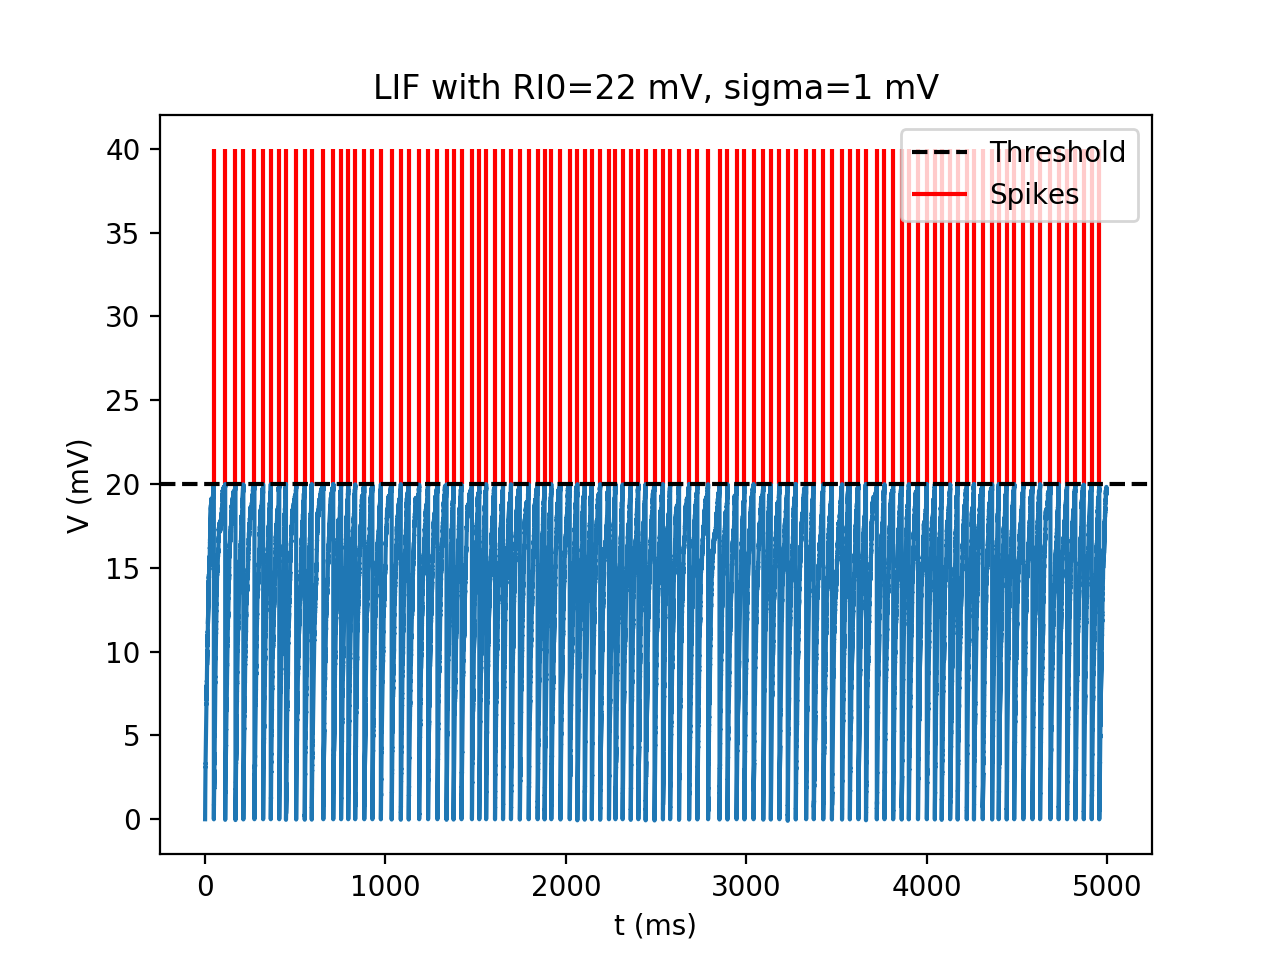

Text(0, 0.5, 'V (mV)')

In [37]:
# Plottez le potentiel de membrane V(t)
# avec les spikes superposés pour les
# valeurs de I et de sigma choisies

fig, ax = plt.subplots()
ax.set_title('LIF with RI0=%g mV, sigma=%g mV'%(R*I1, sigma1))
ax.plot(t, V)
ax.axhline(Vthreshold, c='k', ls='--', label='Threshold')
ax.vlines(spiketimes1, Vseuil, Vseuil+20, colors='r',label='Spikes')
ax.legend()
ax.set_xlabel('t (ms)')
ax.set_ylabel('V (mV)')


In [38]:
# Calculer les ISI et le CV
isis = np.diff(spiketimes1) # in ms
rate = 1000/np.mean(isis) # in Hz
cv = np.std(isis)/np.mean(isis)
print('For RI0 = %.1f mV and sigma = %.1f,'%(R*I1,sigma1))
print('the average firing rate is %.2f Hz, with CV %.2f.'%(rate,cv))

For RI0 = 22.0 mV and sigma = 1.0,
the average firing rate is 21.19 Hz, with CV 0.14.


In [51]:
# Activité irrégulière

# choose input current

I2  = 18. # mV
sigma2 = 2. # mV

spiketimes2 = []

# Euler integration
for i in range(nt-1):
    # subthreshold dynamics according to differential equation for V(t)
    # 1. deterministic part
    V[i+1] = V[i] + dt*dVdt(V[i], I2)

    # 2. add noise part
    etai = np.random.normal()
    V[i+1] += np.sqrt(dt/tau)*sigma2*etai


    # check whether we hit the threshold!
    if V[i+1]>Vthreshold:
        spiketimes2.append(dt*i)
        V[i+1] = Vreset

<IPython.core.display.Javascript object>


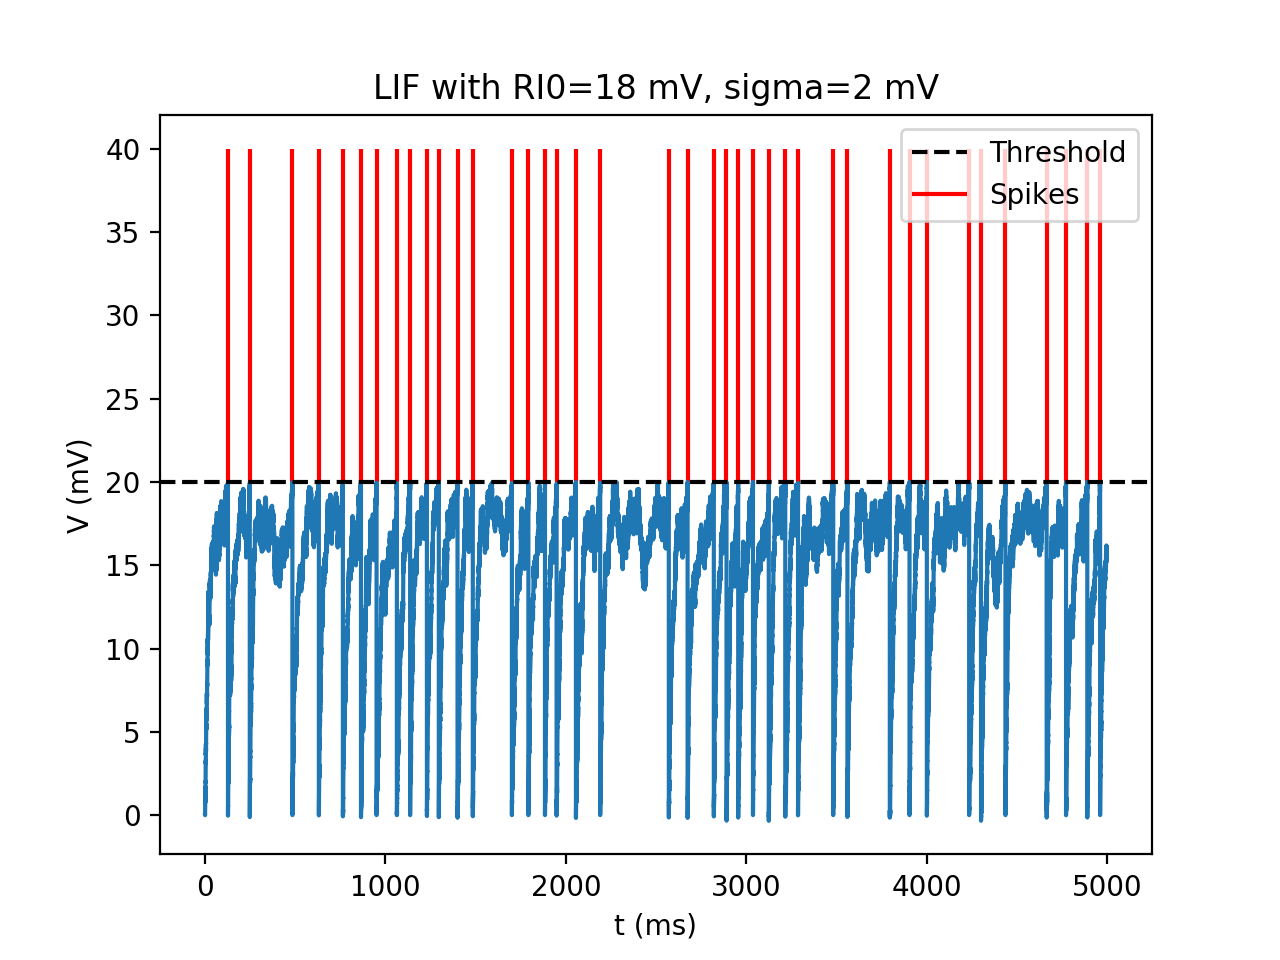

Text(0, 0.5, 'V (mV)')

In [52]:
# Plottez le potentiel de membrane V(t)
# avec les spikes superposés pour les
# valeurs de I et de sigma choisies

fig, ax = plt.subplots()
ax.set_title('LIF with RI0=%g mV, sigma=%g mV'%(R*I2, sigma2))
ax.plot(t, V)
ax.axhline(Vthreshold, c='k', ls='--', label='Threshold')
ax.vlines(spiketimes2, Vseuil, Vseuil+20, colors='r',label='Spikes')
ax.legend()
ax.set_xlabel('t (ms)')
ax.set_ylabel('V (mV)')


In [53]:
# Calculer les ISI et le CV
isis = np.diff(spiketimes2) # in ms
rate = 1000/np.mean(isis) # in Hz
cv = np.std(isis)/np.mean(isis)
print('For RI0 = %.1f mV and sigma = %.1f,'%(R*I2,sigma2))
print('the average firing rate is %.2f Hz, with CV %.2f.'%(rate,cv))

For RI0 = 18.0 mV and sigma = 2.0,
the average firing rate is 8.07 Hz, with CV 0.53.


## BONUS : Distribution des ISI lors d'une activité régulière ou irrégulière 

La différence de CV entre une activité régulière et irrégulière nous permet déjà de distinguer les deux cas. Pour avoir une idée plus précise de la distribution des ISI, plottez l'histogramme des ISI obtenus pour les deux cas que vous avez simulés dans la partie 2 du devoir.

**Astuce :** Utilisez la fonction `ax.hist` pour plotter l'histogramme des valeurs des ISI dans chaqun des deux cas. Affichez l'histogramme avec au moins 25 bins ("keyword argument" `bins=25`, mais vous pouvez essayer d'autres valeurs) pour qu'on puisse bien reconnaître la forme de la distribution. Utilisez également le "keyword argument" `density=True` pour que la hauteur des colonnes soit normalisée par le nombre de valeurs considérées.

Essayez d'estimer le temps de simulation nécessaire pour obtenir environ 1000 spikes dans chaque cas afin d'avoir une résolution raisonable de la distribution, et au besoin repetez la simulation avec un temps plus long si nécesaire.

In [54]:
# simulations plus longues

# paramètres 1: rate = 20 spikes/s -> T = 50s pour 1000 spikes

# Discretization of time
dt = 0.05 # ms (can also choose a bit larger, as long as it is much smaller than tau)
T = 50000 # ms (longer than tau, to see how V behaves on long times)
nt = int(T/dt)
t = dt*np.arange(nt)


V = np.zeros(nt)
V[0] = Vreset # start at reset potential (not necessary)

# choose input current

I1  = 22. # mV
sigma1 = 1. # mV

spiketimes1 = []

# Euler integration
for i in range(nt-1):
    # subthreshold dynamics according to differential equation for V(t)
    # 1. deterministic part
    V[i+1] = V[i] + dt*dVdt(V[i], I1)

    # 2. add noise part
    etai = np.random.normal()
    V[i+1] += np.sqrt(dt/tau)*sigma1*etai


    # check whether we hit the threshold!
    if V[i+1]>Vthreshold:
        spiketimes1.append(dt*i)
        V[i+1] = Vreset

In [55]:
# paramètres 2: rate = 8 spikes/s -> T = 125s pour 1000 spikes

# Discretization of time
dt = 0.05 # ms (can also choose a bit larger, as long as it is much smaller than tau)
T = 125000 # ms (longer than tau, to see how V behaves on long times)
nt = int(T/dt)
t = dt*np.arange(nt)


V = np.zeros(nt)
V[0] = Vreset # start at reset potential (not necessary)

# choose input current

I2  = 18. # mV
sigma2 = 2. # mV

spiketimes2 = []

# Euler integration
for i in range(nt-1):
    # subthreshold dynamics according to differential equation for V(t)
    # 1. deterministic part
    V[i+1] = V[i] + dt*dVdt(V[i], I2)

    # 2. add noise part
    etai = np.random.normal()
    V[i+1] += np.sqrt(dt/tau)*sigma2*etai


    # check whether we hit the threshold!
    if V[i+1]>Vthreshold:
        spiketimes2.append(dt*i)
        V[i+1] = Vreset

<IPython.core.display.Javascript object>


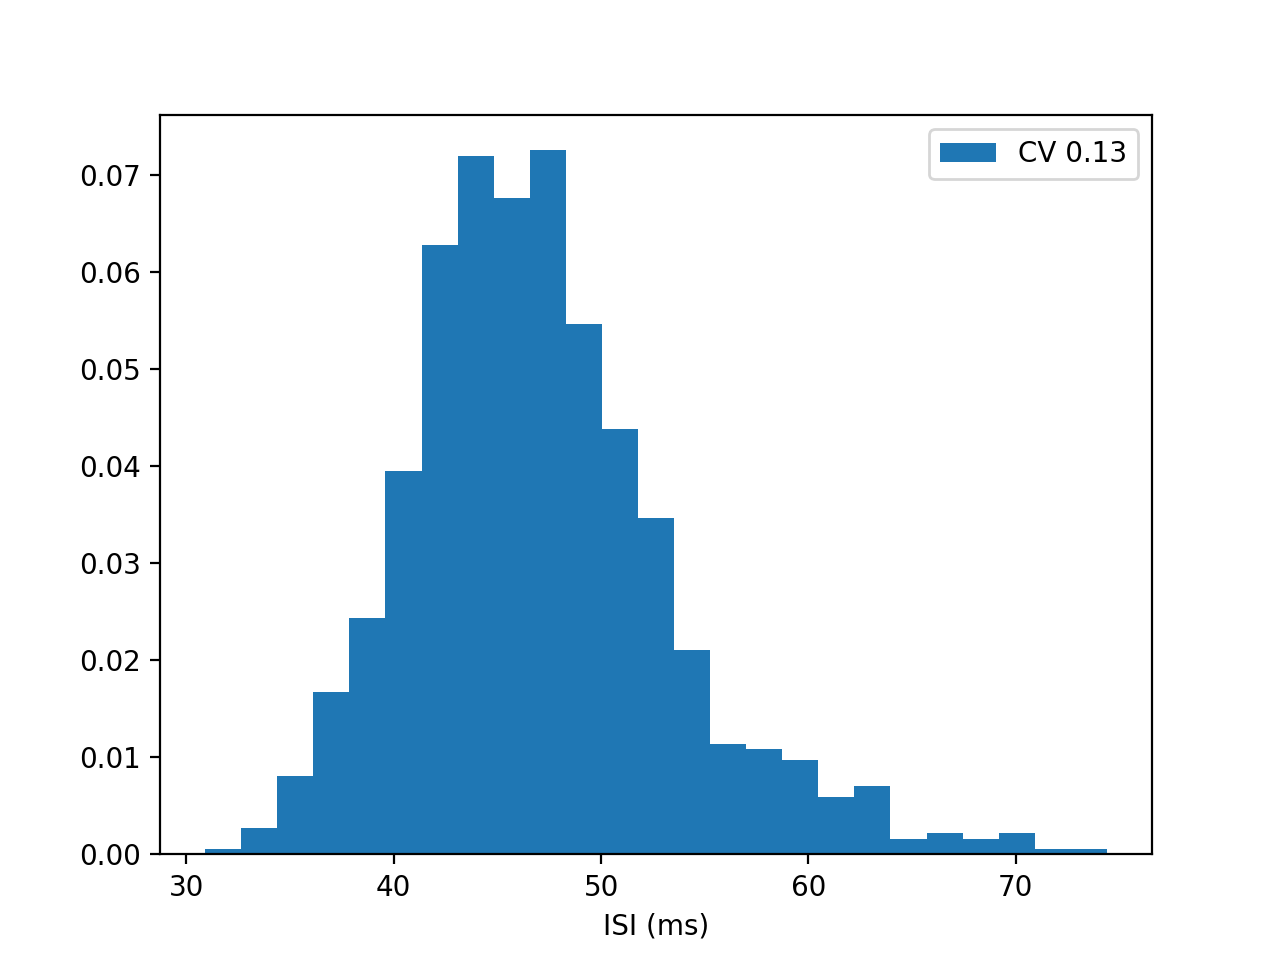

<IPython.core.display.Javascript object>


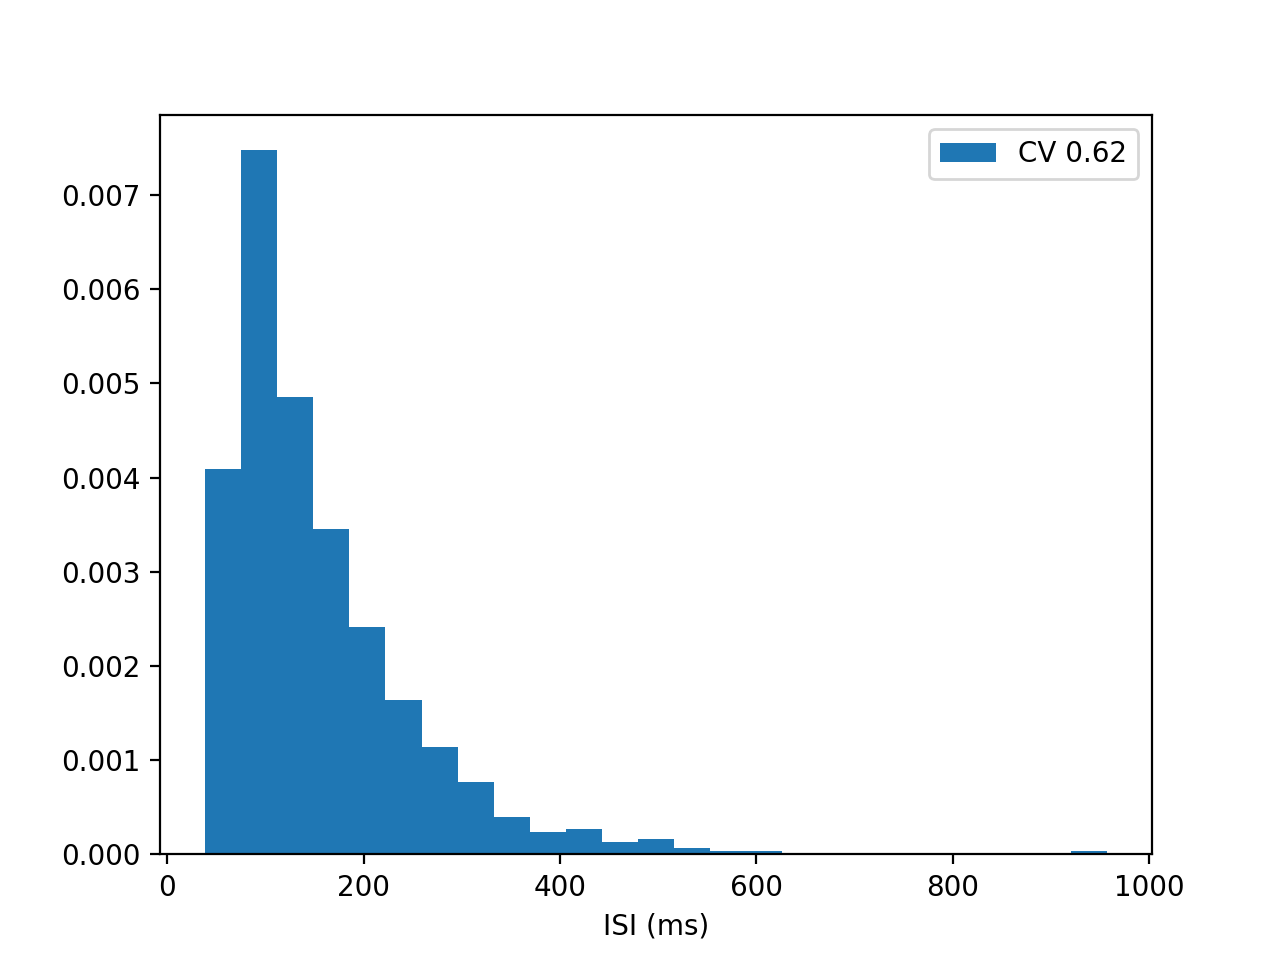

In [60]:
# Distribution des ISI:

isis1 = np.diff(spiketimes1)
cv1 = np.std(isis1)/np.mean(isis1)

fig, ax = plt.subplots()
ax.hist(isis1, bins=25, density=True, label='CV %.2f'%cv1)
ax.set_xlabel('ISI (ms)')
ax.legend()

isis2 = np.diff(spiketimes2)
cv2 = np.std(isis2)/np.mean(isis2)

fig, ax = plt.subplots()
ax.hist(isis2, bins=25, density=True, label='CV %.2f'%cv2)
ax.set_xlabel('ISI (ms)')
ax.legend()